In [61]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_validate, TimeSeriesSplit, ShuffleSplit, StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import BaggingClassifier, StackingClassifier, AdaBoostClassifier, RandomForestClassifier

In [ ]:
x=np.linspace(1,100,10000) 

y=(np.sin(x)+np.random.rand(x.shape[0])*0.3>0.2).astype(int)
x = x.reshape(-1, 1)

Так как X это у нас последовательность, которая последовательно возврастает, то получается что наши данные в своем роде представляют временную ось. Данные имеют временную структуру, где каждое следующее значение X можно рассматривать как более поздний момент времени.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
cvsk = KFold()

In [ ]:
best_depth = 0
best_score = 0
for i in range(1, 100):
  clf = tree.DecisionTreeClassifier(max_depth = i)
  bagging_clf = BaggingClassifier(clf, n_estimators = 5)
  res = cross_validate(bagging_clf, x_train, y_train, cv = cvsk)
  if best_score < res['test_score'].mean():
    best_score = res['test_score'].mean()
    best_depth = i
print(f"Наилучая найденная глубина: {best_depth}")
clf = tree.DecisionTreeClassifier(max_depth = best_depth)
bagging_clf = BaggingClassifier(clf, n_estimators = 5)
bagging_clf = bagging_clf.fit(x_train, y_train)
print(f"Score моей модели = {bagging_clf.score(x_test, y_test)}")
bagging_clf_score = bagging_clf.score(x_test, y_test)

Наилучая найденная глубина: 23
Score моей модели = 0.936


In [65]:
best_depth = 0
best_score = 0
for i in range(1, 100):
  rfc = RandomForestClassifier(max_depth=i, n_estimators=5)
  res = cross_validate(rfc, x_train, y_train, cv = cvsk)
  if best_score < res['test_score'].mean():
    best_score = res['test_score'].mean()
    best_depth = i
print(f"Наилучшая найденная глубина: {best_depth}")
rfc = RandomForestClassifier(max_depth = best_depth)
rfc.fit(x_train, y_train)
print(f"Score моей модели = {rfc.score(x_test, y_test)}")
rfc_score = rfc.score(x_test, y_test)

Наилучшая найденная глубина: 52
Score моей модели = 0.9656


In [66]:
best_depth = 0
best_score = 0
for i in range(1, 100):
  stackingClf = StackingClassifier(
    estimators=[
      ('t1', tree.DecisionTreeClassifier(max_depth=i)),
      ('t2', tree.DecisionTreeClassifier(max_depth=i)),
      ('t3', tree.DecisionTreeClassifier(max_depth=i)),
      ('t4', tree.DecisionTreeClassifier(max_depth=i)),
      ('t5', tree.DecisionTreeClassifier(max_depth=i)),
    ],
    final_estimator=tree.DecisionTreeClassifier(max_depth=i)
  )
  res = cross_validate(stackingClf, x_train, y_train, cv = cvsk)
  if best_score < res['test_score'].mean():
    best_score = res['test_score'].mean()
    best_depth = i
print(f"Наилучшая найденная глубина: {best_depth}")
stackingClf = StackingClassifier(
    estimators=[
      ('t1', tree.DecisionTreeClassifier(max_depth = best_depth)),
      ('t2', tree.DecisionTreeClassifier(max_depth = best_depth)),
      ('t3', tree.DecisionTreeClassifier(max_depth = best_depth)),
      ('t4', tree.DecisionTreeClassifier(max_depth = best_depth)),
      ('t5', tree.DecisionTreeClassifier(max_depth = best_depth)),
    ],
    final_estimator=tree.DecisionTreeClassifier(max_depth = best_depth)
  )
stackingClf.fit(x_train, y_train)
print(f"Score моей модели = {stackingClf.score(x_test, y_test)}")
stackingClf_score = stackingClf.score(x_test, y_test)

Наилучшая найденная глубина: 31
Score моей модели = 0.9656


In [67]:
best_score = 0
best_depth = 0
for i in range(1, 100):
  AdaBoost_clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=i), n_estimators=5)
  res = cross_validate(AdaBoost_clf, x_train, y_train, cv = cvsk)
  if best_score < res['test_score'].mean():
    best_score = res['test_score'].mean()
    best_depth = i
print(f"Наилучшая найденная глубина: {best_depth}")
AdaBoost_clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=best_depth), n_estimators=5)
AdaBoost_clf = AdaBoost_clf.fit(x_train, y_train)
print(f"Score моей модели = {AdaBoost_clf.score(x_test, y_test)}")
AdaBoostClf_score = AdaBoost_clf.score(x_test, y_test)


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

Наилучшая найденная глубина: 7
Score моей модели = 0.9664


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [68]:
x = {"AdaBoost": AdaBoostClf_score, "Bagging":bagging_clf_score, "Random forest":rfc_score, "Stacking":stackingClf_score}
best_model = max(x, key=x.get)
print(f"Лучшая модель: {best_model} (score = {x[best_model]})")

Лучшая модель: AdaBoost (score = 0.9664)


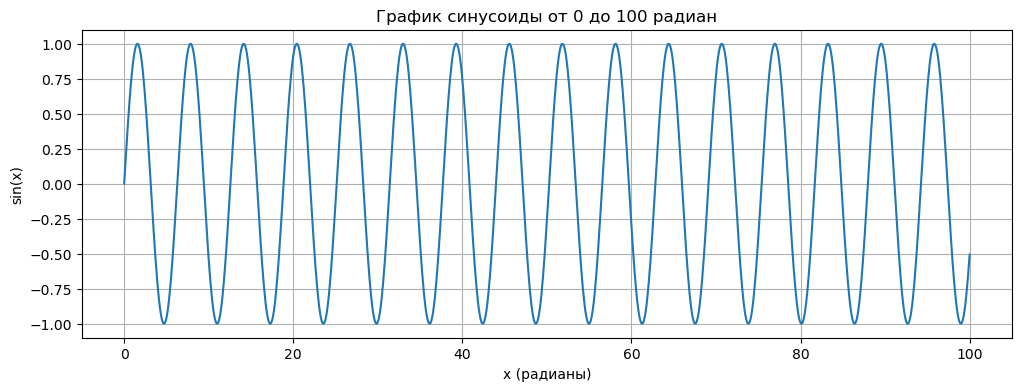

In [70]:
# ...existing code...

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 100, 1000)
y = np.sin(x)

plt.figure(figsize=(12, 4))
plt.plot(x, y)
plt.title("График синусоиды от 0 до 100 радиан")
plt.xlabel("x (радианы)")
plt.ylabel("sin(x)")
plt.grid(True)
plt.show()
# ...existing code...